# Problem
In the capacitated p-median problem there is a set of demand locations (customers) and a set of facility sites (medians). We have to select locations for p-facilities and select for every facility a disjunct subset of customers together with the facility so that the sum of service demands of customers do not exceed the service capacity of their facility and every customer belongs to exactly one facility. The aim is to minimize the total transportation costs while satisfying the demands of the customers from the facilities

## NSGA2 Algorithm
1. Initialize a random population.
2. Create offspring population. (selection, crossover and mutation)
2.1. Crossover: For each facilities in one parent, search for the closest facility in the other parent and place the child facility in the middle of the two parent facilities. 2.2. Mutation: Change locations of the facilities according to a normal distribution.
2. Evaluate parents in a tournament selection by rank and crowding distance. (lexicographic order)
3. Select best parents for reproduction.

5. Evaluate offspring by rank and crowding distance.
6. Create new parents from best frontiers.

### Questions
- Should we implement logic so that a facility cannot have the same coordinates as a customer?
- Should transport cost be calculated as the distance between the facility and the customer * demand? Or is it just the distance between the facility and the customer?

In [264]:
from dataclasses import dataclass
import random
import math
import matplotlib.pyplot as plt

In [265]:
@dataclass
class Customer:
    id: int
    x: float
    y: float
    demand: int

class Facility:
    customers: list[Customer]

    def __init__(self, x, y, capacity) -> None:
        self.x = x
        self.y = y
        self.capacity = capacity
        self.customers = []
    
    def add_customer(self, customer):
        self.customers.append(customer)

    def get_remaining_resources(self):
        used_resources = sum(c.demand for c in self.customers)
        return self.capacity - used_resources
    
    def __repr__(self) -> str:
        return f"Facility at {self.x} {self.y}: {self.customers}"

class Solution:
    def __init__(self, service_distance_score, facility_dispersion_score, facilities: list[Facility]) -> None:
        self.service_distance_score = service_distance_score
        self.facility_dispersion_score = facility_dispersion_score
        self.score = self.service_distance_score + self.facility_dispersion_score
        self.facilities = facilities
        self.rank = -1
        self.distance = 0.0
        self.dominates: list[Solution] = []
        self.dominated_by_count = 0

In [266]:
def parse_p_median(file, target_id):
    current_id = -1
    current_best_value = -1
    with open(file,"r") as f:
        lines = [line.strip() for line in f if line.strip()]
    for i in range(len(lines)):
        parts=lines[i].split()
        if len(parts) == 2:
            current_id=int(parts[0])
            current_best_value=int(parts[1])
            
        if current_id == target_id:
            constraints=lines[i+1].split()
            number_of_customers=int(constraints[0])
            number_of_medians=int(constraints[1])
            capacity_of_medians=int(constraints[2])
            customers=[]
            for j in range(i+2,i+2+number_of_customers):
                each_line=lines[j].split()
                customers.append({
                    "id": int(each_line[0]),
                    "x_coordinate":float(each_line[1]),
                    "y_coordinate":float(each_line[2]),
                    "demand":int(each_line[3])
                })
            return {
                "id": target_id,
                "best_known_value": current_best_value,
                "number_of_medians":number_of_medians,
                "capacity_of_medians":capacity_of_medians,
                "customers":customers
            }
    return dict()

### Calculate metrics for evaluation

In [267]:
def total_service_distance(facilities):
    total = 0.0
    for f in facilities:
        for c in f.customers:
            total += math.sqrt((f.x - c.x) ** 2 + (f.y - c.y) ** 2)
    return total

def total_facility_dispersion(facilities):
    total = 0.0
    n = len(facilities)
    for i in range(n):
        for j in range(i + 1, n):
            fi, fj = facilities[i], facilities[j]
            total += math.sqrt((fi.x - fj.x) ** 2 + (fi.y - fj.y) ** 2)
    return total

### Create parents
Each parent randomly selects p-facilities and assigns customers to the closest facility, given that the facility has enough capacity for the customer. 
We iterate through the customers randomly to make sure that the first customer in the list is not always guaranteed to be assigned to the closest facility.

In [268]:
# assigns customers to facilities
def create_solution(facilities, customers) -> Solution:
    for f in facilities:
        f.customers.clear()

     # assign each customer to the closest facility (if facility has enough resources)
    random.shuffle(customers)
    for c in customers:
        closest_facility_index = -1
        closest_facility_distance = math.inf
        for i, f in enumerate(facilities):
            distance = math.sqrt((f.x - c.x) ** 2 + (f.y - c.y) ** 2)
            if distance < closest_facility_distance and c.demand <= f.get_remaining_resources():
                closest_facility_index = i
                closest_facility_distance = distance
        facilities[closest_facility_index].add_customer(c)
    
    dispersion_score = total_facility_dispersion(facilities)
    service_score = total_service_distance(facilities)
    solution = Solution(service_score, dispersion_score, facilities)
    return solution

In [269]:
def create_parents(num_parents, facility_count, facility_capacity, min_x, max_x, min_y, max_y, customers) -> list[Solution]:
    parents: list[Solution] = []
    for _ in range(num_parents):
        # randomly select facility coordinates
        facilities = list[Facility]()
        for _ in range(facility_count):
            x = random.uniform(min_x, max_x)
            y = random.uniform(min_y, max_y)
            f = Facility(x, y, facility_capacity)
            facilities.append(f)

        solution = create_solution(facilities, customers)
        parents.append(solution)
    return parents

### Calculate fronts
Compare solutions with each other and assign them to fronts based on dominance relationships.

In [270]:
def dominates(a: Solution, b: Solution) -> bool:
    # minimize service_distance, maximize facility_dispersion
    not_worse = (
        a.service_distance_score <= b.service_distance_score
        and a.facility_dispersion_score >= b.facility_dispersion_score
    )
    strictly_better = (
        a.service_distance_score < b.service_distance_score
        or a.facility_dispersion_score > b.facility_dispersion_score
    )
    return not_worse and strictly_better

def calculate_fronts(solutions: list[Solution]):
    for s in solutions:
        s.dominates = []
        s.dominated_by_count = 0
        s.rank = -1
    
    # populate dominance relationship 
    n = len(solutions)
    for i in range(n):
        for j in range(i + 1, n):
            si, sj = solutions[i], solutions[j]
            if dominates(si, sj):
                si.dominates.append(sj)
                sj.dominated_by_count += 1
            if dominates(sj, si):
                sj.dominates.append(si)
                si.dominated_by_count += 1
    
    # assign solutions to frontiers
    current_front = [s for s in solutions if s.dominated_by_count == 0]
    current_rank = 0
    while current_front:
        for s in current_front:
            s.rank = current_rank

        next_front: list[Solution] = []
        for s in current_front:
            for d in s.dominates:
                d.dominated_by_count -= 1
                if d.dominated_by_count == 0:
                    next_front.append(d)

        current_front = next_front
        current_rank += 1
    

### Calculate crowding distance
Calculate the crowding distance for each solution in a front. This is done by sorting the solutions in the front by each objective and calculating the distance between the neighbouring solutions for the current objective. The crowding distance is the sum of the distances for each objective.

In [271]:
def calculate_crowding_distance(front: list[Solution]):
    n = len(front)
    if n == 0:
        return
    if n <= 2:
        for s in front:
            s.distance = math.inf
        return

    for s in front:
        s.distance = 0.0

    # sort by service distance
    by_service = sorted(front, key=lambda x: x.service_distance_score)
    by_service[0].distance = math.inf
    by_service[-1].distance = math.inf
    service_range = by_service[-1].service_distance_score - by_service[0].service_distance_score
    for i in range(1, n - 1):
        by_service[i].distance += (by_service[i + 1].service_distance_score - by_service[i - 1].service_distance_score) / service_range
    
    # sort by service distance
    by_dispersion = sorted(front, key=lambda x: x.facility_dispersion_score)
    by_dispersion[0].distance = math.inf
    by_dispersion[-1].distance = math.inf
    dispersion_range = by_dispersion[-1].facility_dispersion_score - by_dispersion[0].facility_dispersion_score
    for i in range(1, n - 1):
        by_dispersion[i].distance += (by_dispersion[i + 1].facility_dispersion_score - by_dispersion[i - 1].facility_dispersion_score) / dispersion_range 

def calculate_population_crowding_distance(solutions: list[Solution]):
    fronts: dict[int, list[Solution]] = {}
    for s in solutions:
        fronts.setdefault(s.rank, []).append(s)

    for rank in sorted(fronts.keys()):
        calculate_crowding_distance(fronts[rank])

### Choose parents for reproduction
Select parents for reproduction by tournament selection.

In [272]:
def tournament_selection(number_of_parents, solutions: list[Solution]) -> list[Solution]:
    best_solutions: list[Solution] = []
    for _ in range(number_of_parents):
        # get four different solutions
        i1 = random.randint(0, len(solutions) - 1)
        i2 = i1
        while i2 == i1:
            i2 = random.randint(0, len(solutions) - 1)
        s1 = solutions[i1]
        s2 = solutions[i2]
        # add better solution to parents for next generation
        if s1.rank < s2.rank:
            best_solutions.append(s1)
        elif s2.rank < s1.rank:
            best_solutions.append(s2)
        else:
            if s1.distance > s2.distance:
                best_solutions.append(s1)
            else:
                best_solutions.append(s2)
    return best_solutions

### Mutation
Mutate children by changing locations of the facilities according to a normal distribution and reassigning customers to the closest facility, given that the facility has enough capacity for the customer.

In [273]:
def mutate(solutions, customers, min_x: float, max_x: float, min_y: float, max_y: float, mutation_rate = 1.0) -> list[Solution]:
    children: list[Solution] = []
    clip_min_x = min_x - 50
    clip_max_x = max_x + 50
    clip_min_y = min_y - 50
    clip_max_y = max_y + 50

    for solution in solutions:
        # mutate this solution with given probability
        if random.random() >= mutation_rate:
            continue
    
        # move all facilities value extracted from normal distribution
        for f in solution.facilities:
            new_x = f.x + random.gauss(0, 10)
            new_y = f.y + random.gauss(0, 10)
            new_x = min(max(new_x, clip_min_x), clip_max_x)
            new_y = min(max(new_y, clip_min_y), clip_max_y)
            f.x = new_x
            f.y = new_y
        
        child = create_solution(solution.facilities, customers)
        children.append(child)
    return children

### Crossover
Cross two parents over by placing the child facilities in the middle of the parent facilities. For each facilities in one parent, search for the closest facility in the other parent and place the child facility in the middle of the two parent facilities.

In [274]:
def euclidean(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def create_child_facilities(a: Solution, b: Solution) -> list[Facility]:
    child_facilities: list[Facility] = []
    for fa in a.facilities:
        fb = min(
            b.facilities,
            key=lambda f: euclidean(fa.x, fa.y, f.x, f.y)
        )
        new_x = (fa.x + fb.x) / 2.0
        new_y = (fa.y + fb.y) / 2.0
        child_facilities.append(Facility(new_x, new_y, fa.capacity))
    return child_facilities

def crossover(parents: list[Solution], customers: list[Customer]) -> list[Solution]:
    children: list[Solution] = []
    if len(parents) < 2:
        return children

    random.shuffle(parents)
    for i in range(0, len(parents) - 1, 2):
        p1, p2 = parents[i], parents[i + 1]

        c1_facilities = create_child_facilities(p1, p2)
        c2_facilities = create_child_facilities(p2, p1)

        children.append(create_solution(c1_facilities, customers))
        children.append(create_solution(c2_facilities, customers))

    return children

### Parse Dictionary output into objects

In [275]:
problem = parse_p_median("hackathon_instance.txt",1)
best_known_value = problem["best_known_value"]
facility_count = problem["number_of_medians"]
facility_capacity = problem["capacity_of_medians"]

# get minimum and maximum coordinates
min_x, max_x, min_y, max_y = math.inf,0,math.inf,0
customers = list[Customer]()
for item in problem["customers"]:
    x, y = item["x_coordinate"], item["y_coordinate"]
    if x < min_x:
        min_x = x
    if x > max_x:
        max_x = x
    if y < min_y:
        min_y = y
    if y > max_y:
        max_y = y
    c = Customer(item["id"], x, y, item["demand"])
    customers.append(c)

### Main loop

In [276]:
POPULATION_SIZE = 50
MUTATION_RATE = 1
NUMBER_OF_GENERATION = 50

# create initial population
parents = create_parents(POPULATION_SIZE, facility_count, facility_capacity, min_x, max_x, min_y, max_y, customers)
for _ in range(NUMBER_OF_GENERATION):
    # mutate some part of the population
    children = mutate(parents, customers, min_x, max_x, min_y, max_y, MUTATION_RATE)
    # crossover parents to create new children
    crossed = crossover(parents, customers)
    # use the entire population (normal + mutation + crossover)
    population = parents + children + crossed
    # calculate the frontiers and distances for every solution
    calculate_fronts(population)
    calculate_population_crowding_distance(population)
    # select best new parents with tournament selection
    parents = tournament_selection(POPULATION_SIZE, population)

parents.sort(key=lambda x: x.score)
best_solution = parents[0]

ZeroDivisionError: division by zero

In [ ]:
print(best_solution.service_distance_score, best_solution.facility_dispersion_score, best_solution.facilities)

2666.612169147775 3768.8082075771185 [Facility at -15.546237340668426 17.512841544384: [Customer(id=16, x=5.0, y=27.0, demand=14), Customer(id=48, x=9.0, y=9.0, demand=13), Customer(id=76, x=58.0, y=7.0, demand=17), Customer(id=28, x=53.0, y=10.0, demand=7), Customer(id=33, x=8.0, y=26.0, demand=20), Customer(id=100, x=18.0, y=34.0, demand=5), Customer(id=24, x=55.0, y=13.0, demand=14), Customer(id=66, x=15.0, y=13.0, demand=10), Customer(id=75, x=44.0, y=9.0, demand=12), Customer(id=15, x=19.0, y=43.0, demand=5)], Facility at 125.03699178411426 67.70363017870292: [Customer(id=89, x=78.0, y=55.0, demand=4), Customer(id=68, x=100.0, y=62.0, demand=10), Customer(id=60, x=94.0, y=73.0, demand=1), Customer(id=92, x=95.0, y=24.0, demand=19), Customer(id=25, x=84.0, y=57.0, demand=13), Customer(id=81, x=95.0, y=72.0, demand=16), Customer(id=43, x=92.0, y=34.0, demand=18), Customer(id=2, x=80.0, y=25.0, demand=8), Customer(id=58, x=100.0, y=17.0, demand=19), Customer(id=40, x=75.0, y=21.0, de

### Visualize fronts

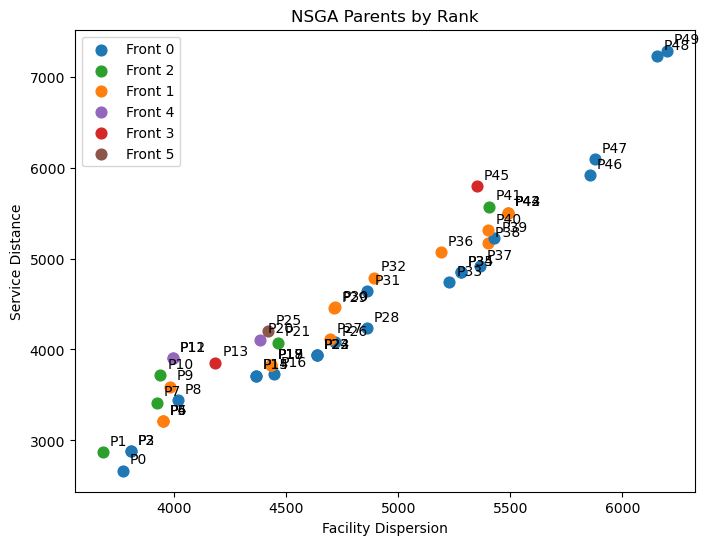

In [ ]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("tab10")

for i, s in enumerate(parents):
    rank = s.rank
    color = cmap(rank % 10)
    label = f"Front {rank}"

    # avoid duplicate legend entries
    if label not in plt.gca().get_legend_handles_labels()[1]:
        plt.scatter(
            s.facility_dispersion_score,
            s.service_distance_score,
            color=color,
            s=60,
            label=label
        )
    else:
        plt.scatter(
            s.facility_dispersion_score,
            s.service_distance_score,
            color=color,
            s=60
        )

    plt.annotate(
        f"P{i}",
        (s.facility_dispersion_score, s.service_distance_score),
        xytext=(5, 5),
        textcoords="offset points"
    )

plt.xlabel("Facility Dispersion")
plt.ylabel("Service Distance")
plt.title("NSGA Parents by Rank")
plt.legend()
plt.show()

### Visualize facility placements

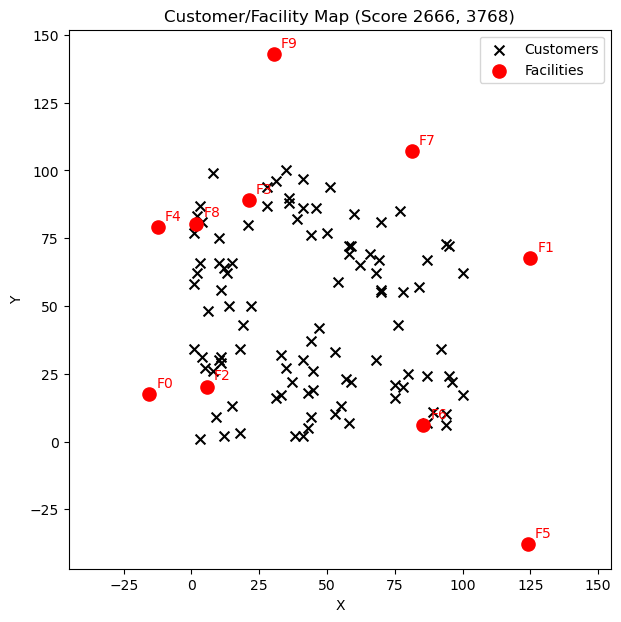

In [ ]:
plt.figure(figsize=(7, 7))

# plot customers
cx = [c.x for c in customers]
cy = [c.y for c in customers]
plt.scatter(cx, cy, marker="x", color="black", s=50, label="Customers")

# plot facilities
fx = [f.x for f in best_solution.facilities]
fy = [f.y for f in best_solution.facilities]
plt.scatter(fx, fy, marker="o", color="red", s=90, label="Facilities")

# annotate facilities
for i, f in enumerate(best_solution.facilities):
    plt.annotate(f"F{i}", (f.x, f.y), xytext=(5, 5), textcoords="offset points", color="red")

score = best_solution.service_distance_score + best_solution.facility_dispersion_score

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Customer/Facility Map (Score {int(best_solution.service_distance_score)}, {int(best_solution.facility_dispersion_score)})")
plt.legend()
plt.axis("equal")
plt.show()

## SPEA Algorithm

In [ ]:
from math import sqrt as sqrt
import matplotlib.pyplot as plt
import random
import numpy as np 
import pandas as pd

### Algorithm

In [ ]:
def parse_p_median(file, target_id, target_best_value):
    with open(file,"r") as f:
        lines = [line.strip() for line in f if line.strip()]
    i=0
    while i<len(lines):
        parts=lines[i].split()
        if len(parts)==2:
            current_id=int(parts[0])
            current_best_value=int(parts[1])
        if current_id==target_id and current_best_value==target_best_value:
            constraints=lines[i+1].split()
            number_of_customers=int(constraints[0])
            number_of_medians=int(constraints[1])
            capacity_of_medians=int(constraints[2])
            customers=[]
            for j in range(i+2,i+2+number_of_customers):
                each_line=lines[j].split()
                customers.append({
                    "id": int(each_line[0])-1,
                    "x_coordinate":float(each_line[1]),
                    "y_coordinate":float(each_line[2]),
                    "demand":int(each_line[3])
                })
            return {
                "number_of_medians":number_of_medians,
                "capacity_of_medians":capacity_of_medians,
                "customers":customers
            }
        i+=1
    return None
        

### Constraints

In [ ]:
#Constraints- we have a fixed number of facilities to place and each facility has a maximum capacity
def constraints(chosen_facilities, all_customers,dist_matrix,max_capacity):
    remaining_capacity={m_id:max_capacity for m_id in chosen_facilities}
    total_service_distance=0
    sorted_customers=sorted(all_customers,key=lambda k:k['demand'],reverse=True)
    for customer in sorted_customers:
        customer_id=customer['id']
        distances=[]
        for facility in chosen_facilities:
            d=dist_matrix[customer_id][facility]
            distances.append((facility,d))
        distances.sort(key=lambda x:x[1])
        assigned=False
        for facility_id, dist in distances:
            if remaining_capacity[facility_id]>=customer['demand']:
                remaining_capacity[facility_id]-=customer['demand']
                total_service_distance+=dist
                assigned=True
                break
        if not assigned:
            return float('inf'), 0
    return total_service_distance, True
def dispersion(chosen_facilities,dist_matrix):
    total_dispersion=0
    p=len(chosen_facilities)
    for i in range(p):
        for j in range (i+1,p):
            m1=chosen_facilities[i]
            m2=chosen_facilities[j]
            total_dispersion+=dist_matrix[m1][m2]
    return total_dispersion
#Objective A- minimize facility distance(we want them to be as close to their respective customers as possible)
#Objective B- we want the facilities to be spread far apart from each other

In [ ]:
def population_initialization(population_size,number_of_facilities,customer_data,number_of_customer,dist_matrix,max_capacity):
   population=[]
   while len(population)<population_size:
      candidate_genes=random.sample(range(number_of_customer),number_of_facilities)
      dist_score,feasibility=constraints(candidate_genes,customer_data,dist_matrix,max_capacity)
      if feasibility==True:
         dispersion_score=dispersion(candidate_genes,dist_matrix)
         individual={
            "genes":candidate_genes,
            "distance_score":dist_score,
            "dispersion_score":dispersion_score
         }
         population.append(individual)
         print(f"Found individual {len(population)}/{population_size}")
   return population
def dominance_function(population):
   for i in range(len(population)):
      count=0
      individual_a=population[i]
      for j in range(len(population)):
         if i==j:
            continue
         individual_b=population[j]
         if ((individual_a['distance_score'] <= individual_b['distance_score']) and (individual_a['dispersion_score']>individual_b['dispersion_score'])) or ((individual_a['distance_score'] < individual_b['distance_score']) and (individual_a['dispersion_score']>=individual_b['dispersion_score'])):
            count+=1
      individual_a['strength']=count
   return population
def raw_fitness(population):
   population=dominance_function(population)
   for i in range(len(population)):
      raw_score=0
      individual_a=population[i]
      for j in range(len(population)):
         if i==j:
            continue
         individual_b=population[j]
         if ((individual_a['distance_score'] >= individual_b['distance_score']) and (individual_a['dispersion_score']<individual_b['dispersion_score'])) or ((individual_a['distance_score'] > individual_b['distance_score']) and (individual_a['dispersion_score']<=individual_b['dispersion_score'])):
            raw_score+=individual_b['strength']
      individual_a['raw_score']=raw_score
   return population
def euclidean_distance(x1, y1, x2, y2):
   return sqrt(((x1-y1)**2)+((x2-y2)**2))
def density_function(population,archive,population_size):
   merge=population+archive
   for i in range(len(merge)):
      all_distances=[]
      individual_a=merge[i]
      for j in range(len(merge)):
         individual_b=merge[j]
         if i==j:
            continue
         distance= euclidean_distance(individual_a['distance_score'],individual_b['distance_score'],individual_a['dispersion_score'],individual_b['dispersion_score'])
         all_distances.append(distance)
      all_distances.sort()
      k=int(sqrt(population_size))
      density=1/(all_distances[k]+2)
      individual_a['final_fitness']=individual_a['raw_score']+density
def truncate_archive(archive, archive_size):
   while len(archive)>archive_size:
      neighbour_distances=[]
      for i in range(len(archive)):
         all_distances=[]
         individual_a=archive[i]
         for j in range(len(archive)):
            individual_b=archive[j]
            if i==j:
               continue
            distance= euclidean_distance(individual_a['distance_score'],individual_b['distance_score'],individual_a['dispersion_score'],individual_b['dispersion_score'])
            all_distances.append(distance)
         all_distances.sort()
         neighbour_distances.append(all_distances)
      victim_index = neighbour_distances.index(min(neighbour_distances))
      archive.pop(victim_index)
   return archive      
def environmental_selection(final_population, archive_size):
   new_archive=[ind for ind in final_population if ind['final_fitness']<1]
   if len(new_archive)==archive_size:
      return new_archive
   elif len(new_archive)<archive_size:
      dominated_individuals=[ind for ind in final_population if ind['final_fitness']>=1]
      dominated_individuals.sort(key=lambda x:x['final_fitness'])
      needed_individuals=archive_size-len(new_archive)
      new_archive.extend(dominated_individuals[:needed_individuals])
      return new_archive
   elif len(new_archive)>archive_size:
      return truncate_archive(new_archive,archive_size)
def binary_tournament(archive, population_size, p, number_of_facilities,customer_data,dist_matrix,max_capacity):
   population=[]
   while(len(population)<population_size):
      individual_a=random.choice(archive)
      individual_b=random.choice(archive)
      if individual_a['final_fitness']<individual_b['final_fitness']:
         parent_a=individual_a
      else:
         parent_a=individual_b
      individual_c=random.choice(archive)
      individual_d=random.choice(archive)
      if individual_c['final_fitness']<individual_d['final_fitness']:
         parent_b=individual_c
      else:
         parent_b=individual_d
      #Crossover
      gene_pool = list(set(parent_a['genes'] + parent_b['genes']))
      if len(gene_pool)>=p:
         child_genes = random.sample(gene_pool, p)
      else:
         child_genes = parent_a['genes'][:]
      #Mutation
      if random.random() < 0.10:
         mutate_idx = random.randint(0, p - 1)
         available = [f for f in range(number_of_facilities) if f not in child_genes]
         if available:
            child_genes[mutate_idx] = random.choice(available)
      dist_score, is_feasible = constraints(child_genes, customer_data, dist_matrix, max_capacity)
      if is_feasible:
         dispersion_score=dispersion(child_genes,dist_matrix)
         child = {
                'genes': child_genes,
                'distance_score': dist_score,
                'dispersion_score': dispersion_score
            }
         population.append(child)
   return population

Generating initial valid population...
Found individual 1/50
Found individual 2/50
Found individual 3/50
Found individual 4/50
Found individual 5/50
Found individual 6/50
Found individual 7/50
Found individual 8/50
Found individual 9/50
Found individual 10/50
Found individual 11/50
Found individual 12/50
Found individual 13/50
Found individual 14/50
Found individual 15/50
Found individual 16/50
Found individual 17/50
Found individual 18/50
Found individual 19/50
Found individual 20/50
Found individual 21/50
Found individual 22/50
Found individual 23/50
Found individual 24/50
Found individual 25/50
Found individual 26/50
Found individual 27/50
Found individual 28/50
Found individual 29/50
Found individual 30/50
Found individual 31/50
Found individual 32/50
Found individual 33/50
Found individual 34/50
Found individual 35/50
Found individual 36/50
Found individual 37/50
Found individual 38/50
Found individual 39/50
Found individual 40/50
Found individual 41/50
Found individual 42/50
Foun

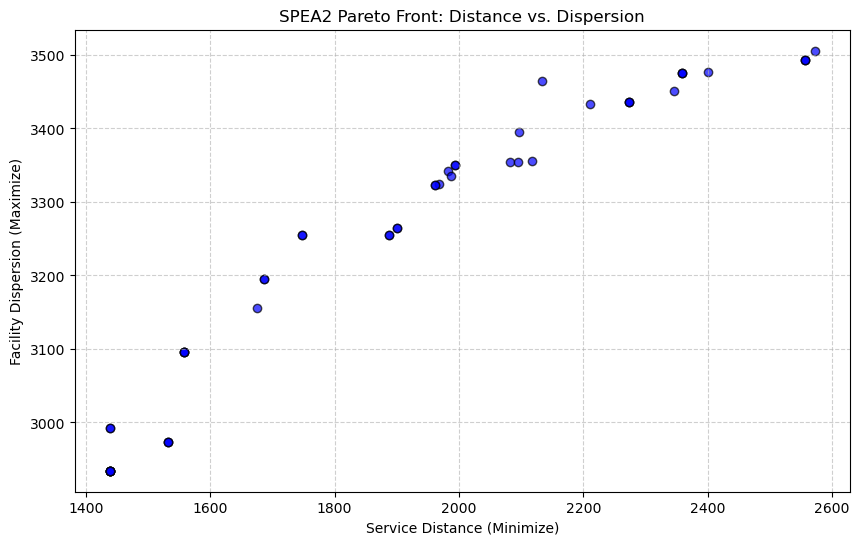

In [ ]:
def build_distance_matrix(customers):
    n = len(customers)
    matrix = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            d = sqrt(
                (customers[i]['x_coordinate'] - customers[j]['x_coordinate'])**2 + 
                (customers[i]['y_coordinate'] - customers[j]['y_coordinate'])**2
            )
            matrix[i][j] = d
            matrix[j][i] = d
    return matrix

raw_data = parse_p_median("p_median_capacitated_hackathon_instance_b.txt", 10, 720)

if raw_data:
    customer_data = raw_data['customers']
    number_of_customers = len(customer_data)
    number_of_facilities = number_of_customers 
    max_capacity = raw_data['capacity_of_medians']
    p_to_select = raw_data['number_of_medians']
    dist_matrix = build_distance_matrix(customer_data)
    capacity_list = [max_capacity] * number_of_facilities
    demand_list = [c['demand'] for c in customer_data]
else:
    print("Instance not found!")
    exit()

#CONFIGURATION
POP_SIZE = 50
ARCHIVE_SIZE = 50
MAX_GENS = 75

print("Generating initial valid population...")
population = population_initialization(
    POP_SIZE, p_to_select, customer_data, number_of_customers, dist_matrix, max_capacity
)
archive = []

print(f"Starting Evolution...")

for gen in range(MAX_GENS):
    combined = population + archive
    combined = raw_fitness(combined) 
    density_function(population, archive, POP_SIZE)
    archive = environmental_selection(combined, ARCHIVE_SIZE)
    
    if not archive:
        print(f"Gen {gen:03} | Archive is empty - searching for better solutions...")
        combined.sort(key=lambda x: x.get('final_fitness', 999))
        archive = combined[:ARCHIVE_SIZE]
    else:
        current_min_dist = min(ind['distance_score'] for ind in archive)
        current_max_disp = max(ind['dispersion_score'] for ind in archive)
        print(f"Gen {gen:03} | Best Distance: {current_min_dist:.2f} | Max Dispersion: {current_max_disp:.2f}")
    
    population = binary_tournament(
    archive, POP_SIZE, p_to_select, number_of_facilities,
    customer_data, dist_matrix, max_capacity 
)
print("\nOptimization Complete.")

def plot_results(archive):
    dists = [ind['distance_score'] for ind in archive]
    disps = [ind['dispersion_score'] for ind in archive]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(dists, disps, c='blue', edgecolors='k', alpha=0.7)
    plt.title('SPEA2 Pareto Front: Distance vs. Dispersion')
    plt.xlabel('Service Distance (Minimize)')
    plt.ylabel('Facility Dispersion (Maximize)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_results(archive)

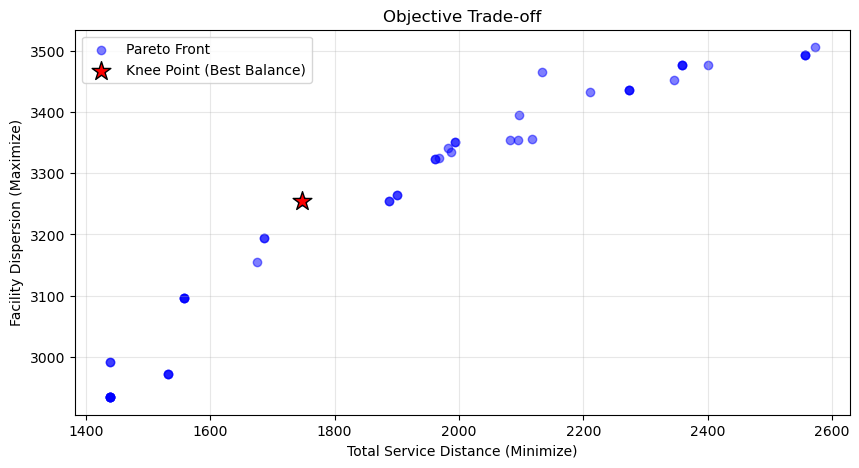

Customer List : [(59, 5), (57, 11), (15, 32), (46, 76), (6, 9), (6, 16), (0, 17), (46, 46), (6, 48), (57, 57), (6, 64), (96, 69), (46, 83), (57, 91), (46, 4), (96, 22), (46, 36), (57, 42), (46, 72), (78, 87), (6, 6), (6, 61), (19, 75), (19, 19), (96, 41), (77, 77), (78, 78), (59, 80), (96, 82), (0, 90), (15, 28), (0, 81), (96, 85), (15, 15), (0, 20), (19, 23), (19, 26), (0, 38), (77, 21), (59, 24), (77, 25), (77, 33), (59, 37), (77, 47), (96, 55), (59, 84), (77, 95), (96, 45), (0, 49), (77, 54), (19, 60), (78, 70), (77, 74), (15, 89), (15, 68), (77, 86), (96, 10), (78, 31), (15, 65), (59, 67), (59, 94), (19, 7), (0, 43), (19, 1), (46, 3), (78, 40), (6, 44), (19, 27), (57, 34), (19, 39), (19, 52), (59, 58), (78, 79), (15, 97), (15, 30), (59, 66), (15, 73), (78, 96), (0, 0), (78, 13), (15, 14), (0, 50), (15, 56), (15, 99), (78, 12), (77, 18), (19, 53), (78, 62), (59, 88), (59, 29), (0, 35), (15, 63), (19, 93), (78, 2), (0, 51), (19, 71), (57, 8), (59, 59), (96, 92), (59, 98)]
Facilities 

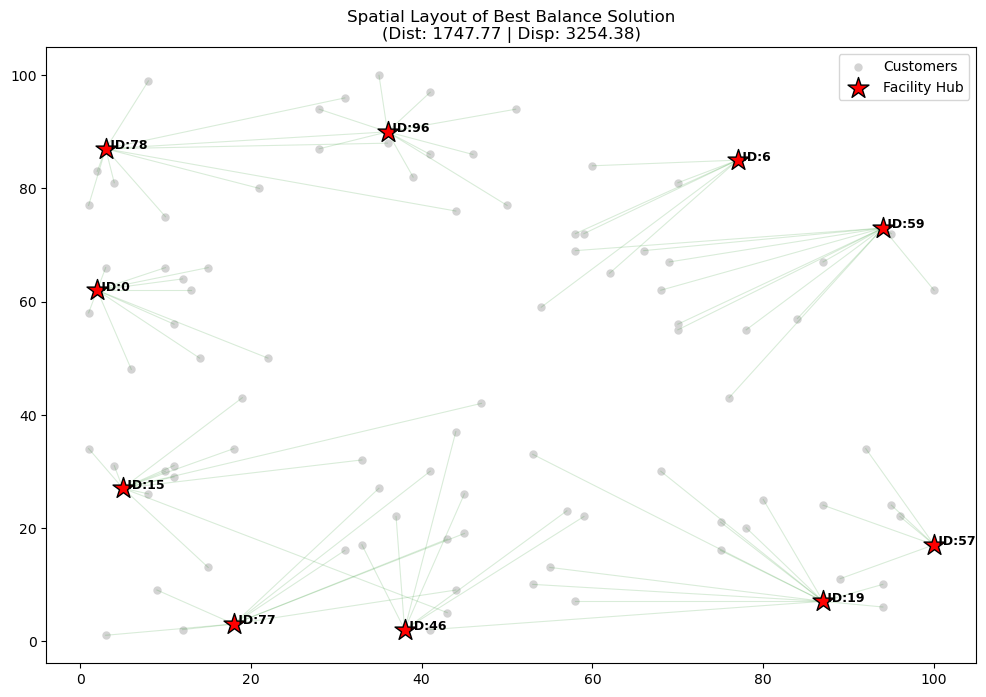

In [ ]:
def plot_final_analysis(archive, customer_data, dist_matrix, max_capacity):
    data = []
    for ind in archive:
        data.append({
            'Distance': ind['distance_score'],
            'Dispersion': ind['dispersion_score']
        })
    df = pd.DataFrame(data)

    # Normalize to find the best balance (Min Distance, Max Dispersion)
    dist_min, dist_max = df['Distance'].min(), df['Distance'].max()
    disp_min, disp_max = df['Dispersion'].min(), df['Dispersion'].max()
    
    df['dist_norm'] = (df['Distance'] - dist_min) / (dist_max - dist_min + 1e-6)
    df['disp_norm'] = (df['Dispersion'] - disp_min) / (disp_max - disp_min + 1e-6)
    
    # Distance to the "Ideal" point (0, 1)
    df['dist_to_ideal'] = np.sqrt(df['dist_norm']**2 + (1 - df['disp_norm'])**2)
    knee_idx = df['dist_to_ideal'].idxmin()
    best_ind = archive[knee_idx]

    #GRAPH A: ANNOTATED PARETO FRONT
    plt.figure(figsize=(10, 5))
    plt.scatter(df['Distance'], df['Dispersion'], c='blue', label='Pareto Front', alpha=0.5)
    plt.scatter(best_ind['distance_score'], best_ind['dispersion_score'], 
                c='red', marker='*', s=200, label='Knee Point (Best Balance)', edgecolors='black')
    plt.title("Objective Trade-off")
    plt.xlabel("Total Service Distance (Minimize)")
    plt.ylabel("Facility Dispersion (Maximize)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # GRAPH B: SPATIAL ASSIGNMENT MAP
    chosen_facilities = best_ind['genes']
    remaining_capacity = {f_id: max_capacity for f_id in chosen_facilities}
    assignments = []
    
    sorted_customers = sorted(customer_data, key=lambda k: k['demand'], reverse=True)
    for customer in sorted_customers:
        c_id = customer['id']
        fac_dists = sorted([(f, dist_matrix[c_id][f]) for f in chosen_facilities], key=lambda x: x[1])
        for f_id, _ in fac_dists:
            if remaining_capacity[f_id] >= customer['demand']:
                remaining_capacity[f_id] -= customer['demand']
                assignments.append((c_id, f_id))
                break

    plt.figure(figsize=(12, 8))
    assigned_customer_list=[]
    facility_coordinates=[]
    
    # Plot Customers
    cust_x = [c['x_coordinate'] for c in customer_data]
    cust_y = [c['y_coordinate'] for c in customer_data]
    plt.scatter(cust_x, cust_y, c='lightgray', s=25, label='Customers', zorder=1)
    
    for c_id, f_id in assignments:
        c_node = next(c for c in customer_data if c['id'] == c_id)
        f_node = next(c for c in customer_data if c['id'] == f_id)
        assigned_customer_list.append((f_id,c_id))
        plt.plot([c_node['x_coordinate'], f_node['x_coordinate']], 
                 [c_node['y_coordinate'], f_node['y_coordinate']], 
                 'g-', alpha=0.15, linewidth=0.8, zorder=2)
    print("Customer List :",assigned_customer_list)
    # Plot Selected Facilities
    for f_id in chosen_facilities:
        f_node = next(c for c in customer_data if c['id'] == f_id)
        plt.scatter(f_node['x_coordinate'], f_node['y_coordinate'], 
                    c='red', marker='*', s=250, edgecolors='black', label='Facility Hub' if f_id == chosen_facilities[0] else "", zorder=3)
        plt.text(f_node['x_coordinate'], f_node['y_coordinate'], f" ID:{f_id}", fontsize=9, fontweight='bold')
        facility_coordinates.append((f_id,f_node['x_coordinate'],f_node['y_coordinate']))
    print("Facilities Coordinates:",facility_coordinates)
        

    plt.title(f"Spatial Layout of Best Balance Solution\n(Dist: {best_ind['distance_score']:.2f} | Disp: {best_ind['dispersion_score']:.2f})")
    plt.legend()
    plt.show()

# Execute
plot_final_analysis(archive, customer_data, dist_matrix, max_capacity)